In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Load the data

In [2]:
df = pd.read_csv('./churn_all.csv')
df.head()

,state,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,KS,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# Check the quality of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   object 
 1   area_code                      5000 non-null   int64  
 2   phone_number                   5000 non-null   object 
 3   international_plan             5000 non-null   object 
 4   voice_mail_plan                5000 non-null   object 
 5   number_vmail_messages          5000 non-null   int64  
 6   total_day_minutes              5000 non-null   float64
 7   total_day_calls                5000 non-null   int64  
 8   total_day_charge               5000 non-null   float64
 9   total_eve_minutes              5000 non-null   float64
 10  total_eve_calls                5000 non-null   int64  
 11  total_eve_charge               5000 non-null   float64
 12  total_night_minutes            5000 non-null   f

There aren't null values and 'dtypes' are correct

# EDA

Data Distribution visualization

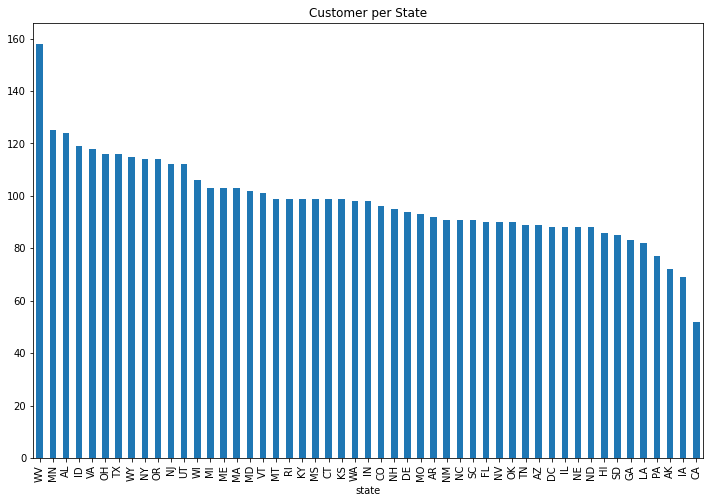

In [4]:
plt.figure(figsize=(12,8))
df['state'].value_counts().plot(kind='bar')
plt.title('Customer per State')
plt.show()

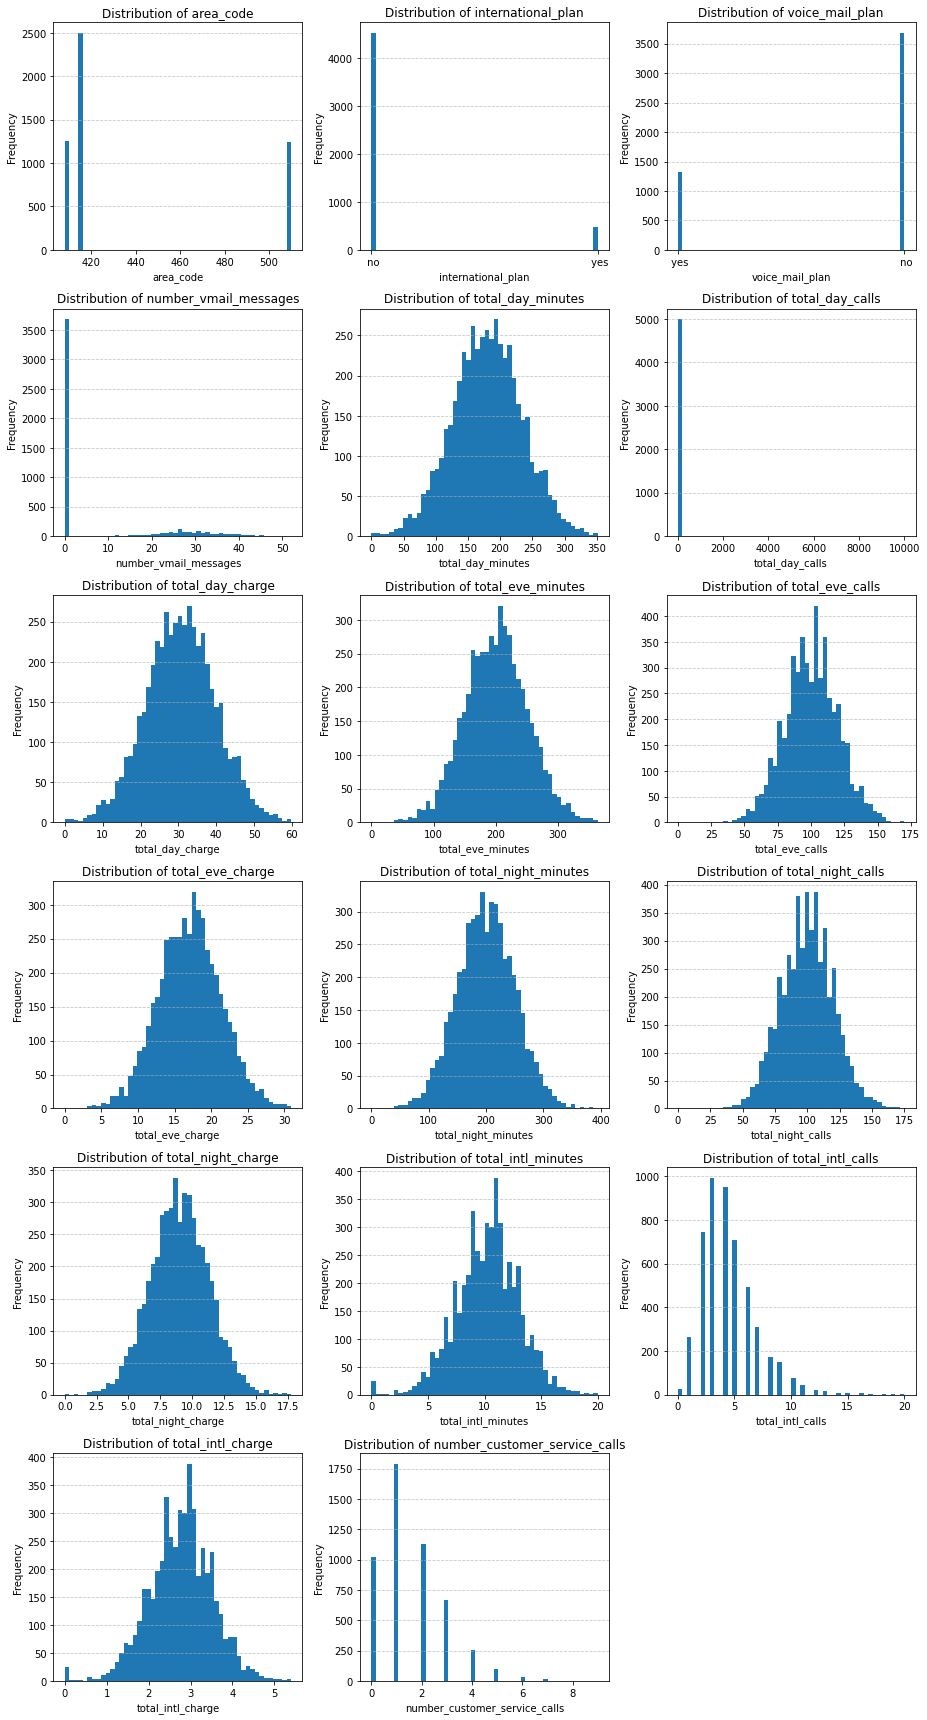

In [5]:
columns = df.columns.to_list()
plot_features = [feature for feature in columns if feature not in ['Churn', 'phone_number', 'state']]

num_features = len(plot_features)
rows = (num_features + 2) // 3  # Calculate rows needed for 3 plots per row

fig, axes = plt.subplots(rows, 3, figsize=(13, 4 * rows))
axes = axes.flatten()  # Flatten axes for easy indexing

for i, feature in enumerate(plot_features):
    ax = axes[i]
    ax.hist(df[feature], bins=50)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hide any unused subplots
for i in range(len(plot_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Categorical vs Numerical features

In [6]:
# Divide the data between categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns =  df.select_dtypes(exclude=['object']).columns.tolist()

print(f'Categorical columns: {categorical_columns}')
print(f'Numerical columns: {numerical_columns}')

Categorical columns: ['state', 'phone_number', 'international_plan', 'voice_mail_plan']
Numerical columns: ['area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'Churn']


In [7]:
# Let's drop 'phone_number' as it shows the same info as 'state'
df.drop(columns='phone_number', inplace=True)

In [8]:
# Convert the categorical features to numerical features
label_encoder = LabelEncoder()

df['state'] = label_encoder.fit_transform(df['state'])
df['international_plan'] = label_encoder.fit_transform(df['international_plan'])
df['voice_mail_plan'] = label_encoder.fit_transform(df['voice_mail_plan'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   int64  
 1   area_code                      5000 non-null   int64  
 2   international_plan             5000 non-null   int64  
 3   voice_mail_plan                5000 non-null   int64  
 4   number_vmail_messages          5000 non-null   int64  
 5   total_day_minutes              5000 non-null   float64
 6   total_day_calls                5000 non-null   int64  
 7   total_day_charge               5000 non-null   float64
 8   total_eve_minutes              5000 non-null   float64
 9   total_eve_calls                5000 non-null   int64  
 10  total_eve_charge               5000 non-null   float64
 11  total_night_minutes            5000 non-null   float64
 12  total_night_calls              5000 non-null   i

## Correlation Matrix

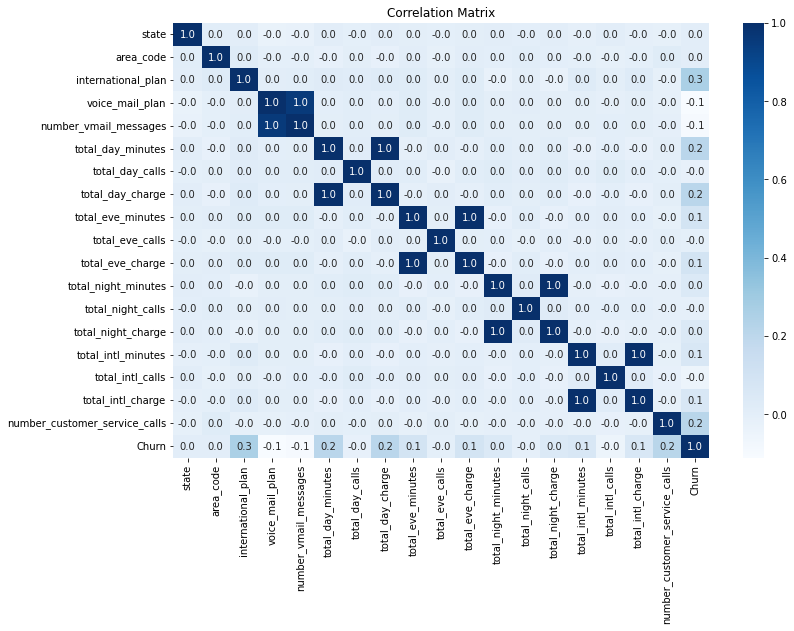

In [10]:
# Check the correlation between features and target 'Churn'
corr_matrix = df.corr()

# Plot the correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

* Values from `features` to `Churn` close to **0.3** indicate a moderate positive correlation, meaning these features have some predictive power for churn and can provide useful insights for the model.
* Highly correlated features should be removed to avoid potential overfitting (performing well on training data but poorly on test data) and to improve model generalization (performing well on unseen test data)

In [11]:
# Drop highly correlated features
df.drop(columns=['total_eve_minutes', 'total_night_minutes', 'total_day_minutes', 'total_intl_minutes', 'number_vmail_messages'], inplace=True)

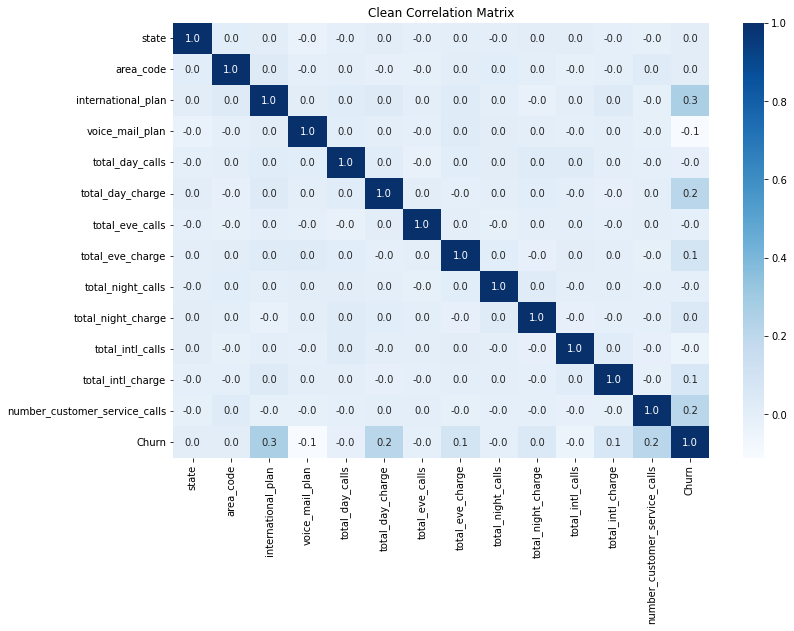

In [12]:
# Create a new correlation matrix
clean_corr_matrix = df.corr()

# Plot again the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(clean_corr_matrix, cmap='Blues', annot=True, fmt='.1f')
plt.title('Clean Correlation Matrix')
plt.show()

Check for imbalanced target data

<Axes: xlabel='Churn'>

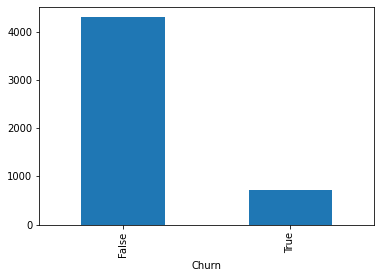

In [13]:
# Churn distribution is imbalanced, we'll need to handle it when training models
df['Churn'].value_counts().plot(kind='bar')

We should handle imbalanced data when training models to avoid the tendency to overpredict the most frequent value, `Churn: False` (No Churn) in this case

# Churn Prediction

We are goint to use the following classifier models to predict the customer churn:
* Logistic Regression
* Random Forest Classifier
* Gradient Boosting (XGBoost)

## Split the data: 80% for training, 20% for testing

The target `Churn` is imbalanced, so we need a balanced data split

In [14]:
# Global parameters
random_state = 50

In [15]:
from sklearn.model_selection import train_test_split

# Features 'X' and target 'y'
X = df.drop(columns='Churn')
y = df['Churn']

# (stratify = y) ensures balanced data split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 13) (4000,)
(1000, 13) (1000,)


## Model Evaluation Pipeline
Pipeline to evaluate all classifier models

In [16]:
# Define pipeline
def evaluate_model(y_test, y_pred, y_prob, model_name):
    
    # Confusion Matrix (true positives, true negatives, false positives, false negatives)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_plot.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"\n{model_name} Results:")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve: {model_name}', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.show()

## 1. Logistic Regression

In [17]:
# Scale the data for Logistic Regression since it is sensible to different numerical ranges 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Train the model
# Class_weight = 'balanced' handles the imbalanced 'Churn' data
logr = LogisticRegression(class_weight='balanced', random_state=random_state)
logr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=50)

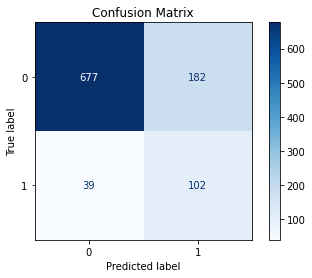


LogisticRegression Results:
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.79      0.86       859
        True       0.36      0.72      0.48       141

    accuracy                           0.78      1000
   macro avg       0.65      0.76      0.67      1000
weighted avg       0.86      0.78      0.81      1000



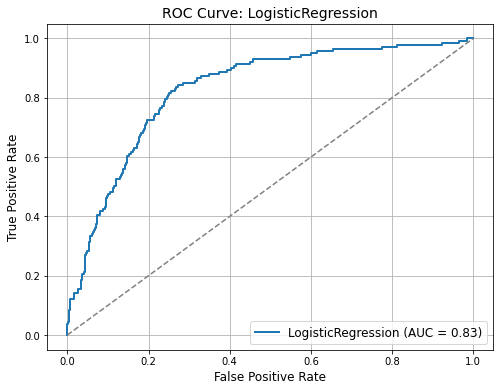

In [18]:
# Let's make the predictions
# Prediction (0: 'no', 1:'yes') and probability([0, 1])
y_pred = logr.predict(X_test_scaled)
y_prob = logr.predict_proba(X_test_scaled)[:, 1]

# Evaluate the Logistic Regression model
evaluate_model(y_test, y_pred, y_prob, 'LogisticRegression')

### 1.2 Logistic Regression: Features Importance

<Axes: ylabel='Feature'>

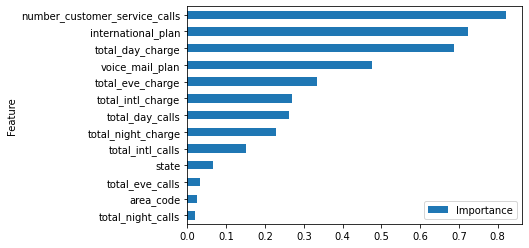

In [19]:
# Extract the importance coefficient per feature
coefficients = logr.coef_[0] 
 
# Add them to a dataframe
lorg_features_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
lorg_features_df.sort_values(by='Importance', ascending=True, inplace=True)

# Plot the features importances
lorg_features_df.plot(kind='barh', x='Feature', y='Importance')

## 2. Random Forest Classifier

In [20]:
# Load and train the model
# We don't need to scale the data form this model since it's a tree-based model

clf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=50)

### 2.1 Random Forest Classifier: Model Evaluation

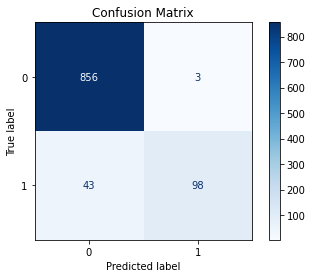


RandomForestClassifier Results:
Classification Report:
               precision    recall  f1-score   support

       False       0.95      1.00      0.97       859
        True       0.97      0.70      0.81       141

    accuracy                           0.95      1000
   macro avg       0.96      0.85      0.89      1000
weighted avg       0.95      0.95      0.95      1000



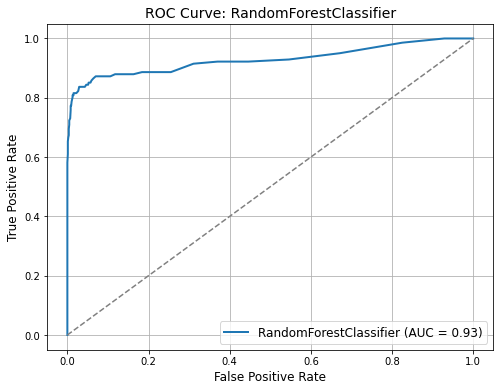

In [21]:
# Let's make the predictions
# Prediction (0: 'no', 1:'yes') and probability([0, 1])
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate the Logistic Regression model
evaluate_model(y_test, y_pred, y_prob, 'RandomForestClassifier')

### 2.2 Random Forest Classifier: Features Importance

<Axes: ylabel='Feature'>

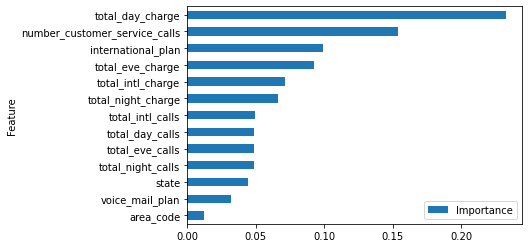

In [22]:
# Get feature importances
clf_feature_importances = clf.feature_importances_
clf_features_df = pd.DataFrame({'Feature': X.columns,'Importance': clf_feature_importances})

# Sort features by importance
clf_features_df.sort_values(by='Importance', ascending=True, inplace=True)

# Plot features
clf_features_df.plot(kind='barh', x='Feature', y='Importance')

## 3. XGBoost Classifier

In [23]:
# Calculate scale_pos_weight to balanced the data
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Load and train the model
# We don't need to scale the data form this model since it's a tree-based
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=random_state)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=50, ...)

### 3.1 XGBoost Classifier: Model Evaluation

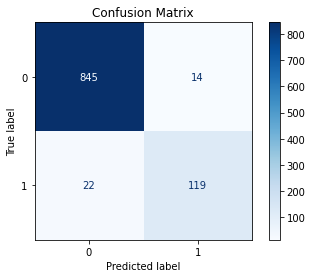


XGBoost Classifier Results:
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.98       859
        True       0.89      0.84      0.87       141

    accuracy                           0.96      1000
   macro avg       0.93      0.91      0.92      1000
weighted avg       0.96      0.96      0.96      1000



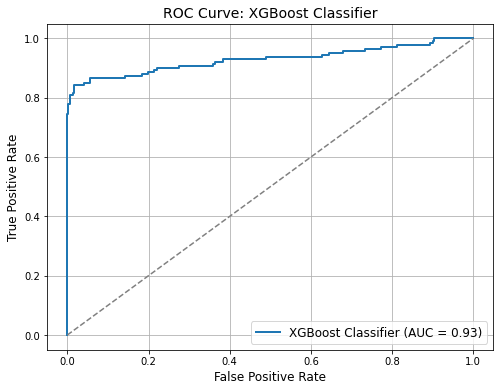

In [24]:
# Let's make the predictions
# Prediction (0: 'no', 1:'yes') and probability([0, 1])
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the Logistic Regression model
evaluate_model(y_test, y_pred, y_prob, 'XGBoost Classifier')

### 3.2 XGBoost Classifier: Feature Importance

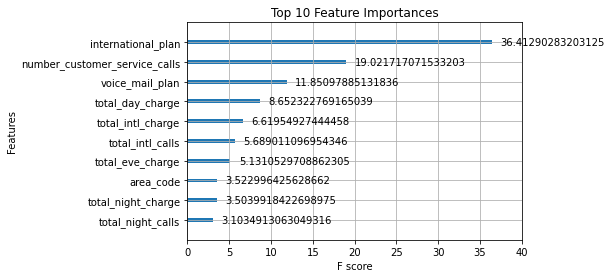

In [25]:
# Plot the most important features
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

## First Conclusions

* `LogisticRegression` model performs poorly compared with `RandomForestClassifier` and `XGBoost` models
* `RandomForestClassifier` and `XGBoost` have similar ROC-Curves, achieving over **90%** of accuracy when predicting True Negatives and over **78%** of accuracy when predicting True Positives, perfoming slightly betther the `XGBoost`model (**84%** accuracy)

## Goal

- Identify as many customers likely to leave (**churn**) as possible to enable proactive retention efforts (**True Positive**).
- Avoid missing customers at risk of churning (**False Negative**) since losing a customer has a more significant impact on the business than mistakenly predicting churn for a customer who stays (**False Positive**).

- Prioritise **Recall** metric to minimize potential losses and enhance retention strategies.

- **Plan**:
    - Compare **Random Forest** and **XGBoost** models
    - Select the model with the best **Recall** for churn prediction

## Cross Validation Score for Recall Comparison

### 1. Random Forest Classifier CV Score

In [26]:
# Cross Validation Score 
clf_cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall')

# Print results
print(f"Cross-Validation Scores for Recall: {clf_cv_scores}")
print(f"Mean Accuracy: {clf_cv_scores.mean():.4f}")

Cross-Validation Scores for Recall: [0.64285714 0.53571429 0.69642857 0.71428571 0.63157895 0.61403509
 0.57894737 0.61403509 0.63157895 0.77192982]
Mean Accuracy: 0.6431


### 2. XGBoost CV Score

In [27]:
# Cross Validation Score 
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='recall')

# Print results
print(f"Cross-Validation Scores for Recall: {xgb_cv_scores}")
print(f"Mean Accuracy: {xgb_cv_scores.mean():.4f}")

Cross-Validation Scores for Recall: [0.69642857 0.76785714 0.875      0.83928571 0.80701754 0.75438596
 0.80701754 0.73684211 0.73684211 0.89473684]
Mean Accuracy: 0.7915


### 3. Compare Models performance against Test Data

In [28]:
# Predictions
clf_y_pred = clf.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)

# Compare Recall
clf_recall = recall_score(y_test, clf_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)

# Compare Precision
clf_precision = precision_score(y_test, clf_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)

print(f"Random Forest Test Recall: {clf_recall:.2f}")
print(f"XGBoost Test Recall: {xgb_recall:.2f}\n")
print(f"Random Forest Test Precision: {clf_precision:.2f}")
print(f"XGBoost Test Precision: {xgb_precision:.2f}")

Random Forest Test Recall: 0.70
XGBoost Test Recall: 0.84

Random Forest Test Precision: 0.97
XGBoost Test Precision: 0.89


## Results Conclusion

- **XGBoost** achieves higher recall (**0.84**) than Random Forest (**0.70**), better capturing churners.
- **Random Forest** has higher precision (**0.97**) than XGBoost (**0.89**), reducing false positives.
- **XGBoost** has higher recall, which aligns better with the goal of minimizing missed churners.
- **XGBoost** as final model for churn prediction.

# Solutions

##  1. Key Characteristics of Customers likely to leave

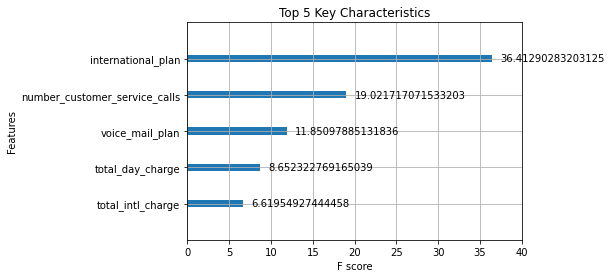

In [29]:
# Features that have most impact when predicting Churn
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=5)
plt.title('Top 5 Key Characteristics')
plt.show()

### 1.1 International Plan vs Churn

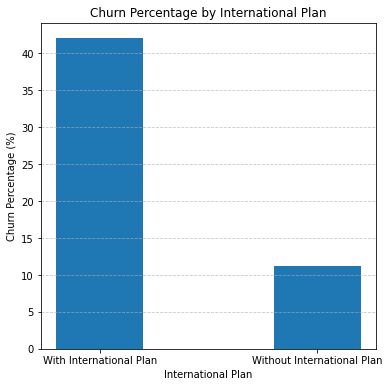

In [30]:
# People with and without an international plan
total_with_plan = df[df['international_plan'] == 1]
total_without_plan = df[df['international_plan'] == 0]

# Calculate churn percentages 
churn_with_plan = total_with_plan['Churn'].mean() * 100  # Mean gives the proportion of churned customers
churn_without_plan = total_without_plan['Churn'].mean() * 100

# Plot
plt.figure(figsize=(6, 6))
plt.bar(['With International Plan', 'Without International Plan'], [churn_with_plan, churn_without_plan], width=0.4)
plt.title('Churn Percentage by International Plan')
plt.ylabel('Churn Percentage (%)')
plt.xlabel('International Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Percetange of `Churn` on people with `international_plan` is higher than 40%, against the 10% of people wihtout `international_plan`

### 1.2 Number_customer_service_calls vs Churn

<Figure size 576x432 with 0 Axes>

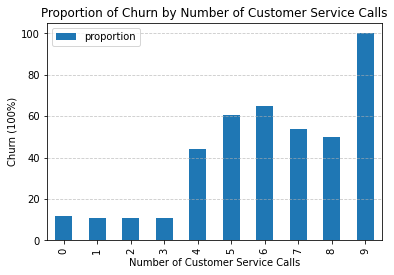

In [31]:
# Calculate percentages
percentages = df.groupby('number_customer_service_calls')['Churn'].value_counts(normalize=True).reset_index(name='proportion')
percentages['proportion'] *= 100

# Plot the graph
plt.figure(figsize=(8, 6))
percentages[percentages['Churn'] == True].plot(kind='bar', x='number_customer_service_calls', y='proportion')
plt.title('Proportion of Churn by Number of Customer Service Calls')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Churn (100%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The Churn percentage increases above **40%** from 4+ `service_calls`. It suggest we must aim to reduce the `service_call` to a minium to avoid that customer's leak from the 4th call.

### 1.3 Voice_mail_plan vs Churn

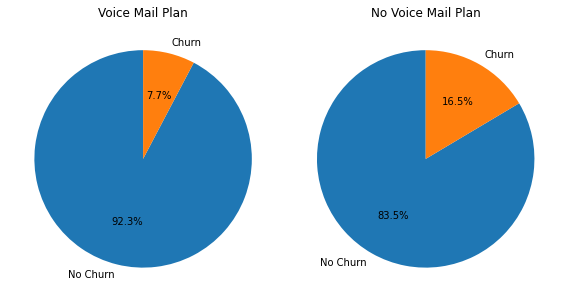

In [32]:
# Parallel pie charts
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Pie chart for Voice Mail Plan
axes[0].pie(df[df['voice_mail_plan'] == 1]['Churn'].value_counts(), labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Voice Mail Plan')

# Pie chart for No Voice Mail Plan
axes[1].pie(df[df['voice_mail_plan'] == 0]['Churn'].value_counts(), labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('No Voice Mail Plan')

plt.tight_layout()
plt.show()

Churn duplicates on people without `voice_mail_plan` compared with people with `voice_mail_plan`

## 2. Customers Likelihood of leaving

In [33]:
# Train the model (after CV or hyperparameter tuning is complete)
final_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=random_state)
final_model.fit(X_train, y_train)

# Make predictions for all customers
churn_probabilities = final_model.predict_proba(X)[:, 1] 

df['churn_probabilities'] = churn_probabilities

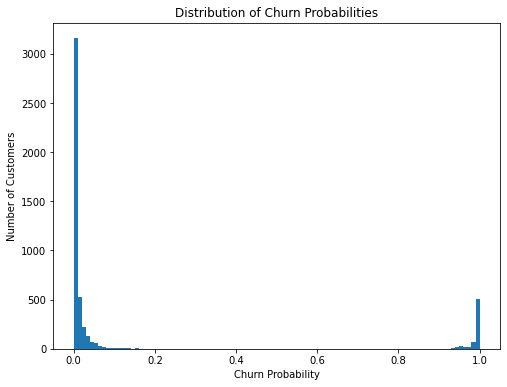

In [34]:
import matplotlib.pyplot as plt

# Assuming `churn_probabilities` contains churn probabilities for all customers
plt.figure(figsize=(8, 6))
plt.hist(churn_probabilities, bins=100)
plt.title('Distribution of Churn Probabilities')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.show()

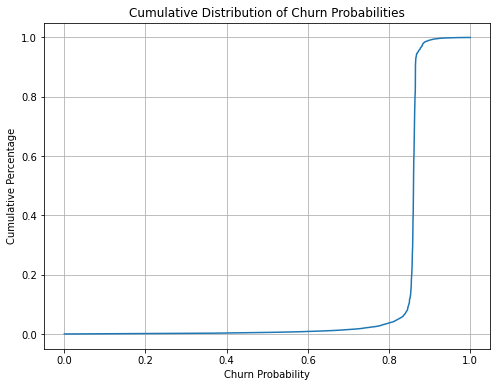

In [45]:
# Sort probabilities
sorted_probs = np.sort(churn_probabilities)
cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(cumulative, sorted_probs)
plt.title('Cumulative Distribution of Churn Probabilities')
plt.xlabel('Churn Probability')
plt.ylabel('Cumulative Percentage')
plt.grid()
plt.show()

Around 85% of Customer aren't likely to Churn (under 20% of chances to Churn) in comparison with around the other last 15% that is highly to churn (above 90% probabilities)

## 3. Top 500 Customers to contact first

In [36]:
# Rank customers by churn probability
ranked_customers = df['churn_probabilities'].sort_values(ascending=False)[:500]
top_500_churn_probability = ranked_customers.index
print(top_500_churn_probability)

Index([ 985, 3205,  914, 1662, 2113, 4991, 3442, 2647, 1339, 2099,
       ...
       2150, 1704, 2290, 3238, 2119, 2412, 3166, 2139, 2980, 2936],
      dtype='int64', length=500)


List of the top 500 customers with the highest likelihood of leaving (churning)

## 4. Evaluating how your strategy compares to randomly contacting the business’ customers 

In [37]:
# Dataset size and churn rate
total_customers = len(df) 
churn_customers = len(df[df['Churn'] == 1]) 
churn_rate = churn_customers / total_customers

print(f'Total customers = {total_customers}')
print(f'Chrun Customers = {churn_customers}')
print(f'Churn Rate = {churn_rate}\n')

# Random Strategy
random_customers = 500  
random_churn_reduction = (random_customers * churn_rate) / total_customers

# Top 500 ranked from XGBoost model and xgb_recall accuracy to identify True Positives
top_customer = 500
high_risk_churn_rate = ranked_customers.mean() * xgb_recall
strategy_churn_reduction = (top_customer * high_risk_churn_rate) / churn_customers

print(f'Random Strategy Churn Reduction: {random_churn_reduction * 100:.2f}%')
print(f'Top 500 high risk Strategy Churn Reduction: {strategy_churn_reduction * 100:.2f}%')

Total customers = 5000
Chrun Customers = 707
Churn Rate = 0.1414

Random Strategy Churn Reduction: 1.41%
Top 500 high risk Strategy Churn Reduction: 59.57%


* Randomly selecting 500 customers will have minimal impact on churn reduction, achieving only **10%**
* Targeting the top 500 high-risk customers will significantly reduce churn by **59.57%** with the model accurately predicting **84.39%** of churn cases. This approach not only minimizes churn but also maximizes profitability by ensuring resources are allocated effectively.

In [38]:
# Parameters for the problem
N = 5000  # Total population size
K = 707   # Total churners in the population
n = 500   # Sample size (randomly selected customers)

# Hypergeometric distribution properties
from scipy.stats import hypergeom

# Calculate the expected number of churners in the random sample
expected_churn_in_sample = hypergeom.mean(M=N, n=K, N=n)

# Reduction in churn
initial_churn = K  # Initial total churners
churn_reduction = expected_churn_in_sample  # Reduction due to strategy
new_churn = initial_churn - churn_reduction  # New total churners
new_churn_rate = new_churn / N  # Updated churn rate

# Results
expected_churn_in_sample, churn_reduction, new_churn, new_churn_rate

(70.7, 70.7, 636.3, 0.12725999999999998)

51.0 66.0 71.0 76.0 91.0


[]

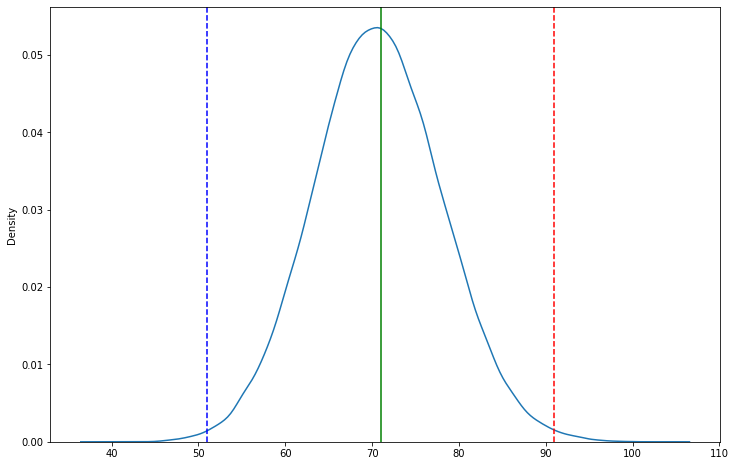

In [39]:
# Parameters for the problem
N = 5000  # Total population size
K = 707   # Total churners in the population
n = 500   # Sample size (randomly selected customers)
n_samples = 50000

sample_list = [df['Churn'].sample(n).value_counts()[True] for i in range(n_samples)]

# Interquartile calculations
q1 = np.percentile(sample_list, 25)
median = np.median(sample_list)
q3 = np.percentile(sample_list, 75)
IQR = q3 - q1
whisker_low = q1 - 1.5 * IQR
whisker_high = q3 + 1.5 * IQR 
print(whisker_low, q1, median, q3, whisker_high)

plt.figure(figsize=(12,8))
sns.kdeplot(sample_list)

plt.axvline(x=whisker_low, color='blue', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(x=median, color='green', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(x=whisker_high, color='red', linestyle='--', label=f'Q3: {q3:.2f}')

plt.plot()

In [40]:
q1 = np.percentile(sample_list, 25)
median = np.median(sample_list)
q3 = np.percentile(sample_list, 75)
IQR = q3 - q1
whisker_low = q1 - 1.5 * IQR
whisker_high = q3 + 1.5 * IQR 
print(whisker_low, q1, median, q3, whisker_high)

51.0 66.0 71.0 76.0 91.0


### Random 500 Customers

In [41]:
# Dataset size and churn rate
total_customers = len(df) 
churn_customers = len(df[df['Churn'] == 1]) 
churn_rate = churn_customers / total_customers

# Random range churn reduction
n_random = 500
low_random_churn_reduction = (churn_rate - (churn_customers - whisker_low) / total_customers) * 100
high_random_churn_reduction = (churn_rate - (churn_customers - whisker_high) / total_customers) * 100
print(f'Random churn reduction will be between {low_random_churn_reduction:.2f}% and {high_random_churn_reduction:.2f}%')

Random churn reduction will be between 1.02% and 1.82%


### Top 500 Customers about to leave (Churn)

In [42]:
# Dataset size and churn rate
total_customers = len(df) 
churn_customers = len(df[df['Churn'] == 1]) 
churn_rate = churn_customers / total_customers

top_customer = 500
high_risk_churn_rate = ranked_customers.mean() * xgb_recall
strategy_churn_reduction = (top_customer * high_risk_churn_rate) / churn_customers

print(f'Top 500 high risk Strategy Churn Reduction: {strategy_churn_reduction * 100:.2f}%')

Top 500 high risk Strategy Churn Reduction: 59.57%


In [43]:
from scipy.stats import hypergeom

N = 5000
n = 500
K = int(xgb_recall * n)
x = range(20,70)

# Intervalo de confianza del 95%
alpha = 0.05
lower_bound = hypergeom.ppf(alpha / 2, N, K, n)    # Percentil 2.5%
upper_bound = hypergeom.ppf(1 - alpha / 2, N, K, n) # Percentil 97.5%

print(f"Intervalo del 95%: [{int(lower_bound)}, {int(upper_bound)}]")

Intervalo del 95%: [31, 54]


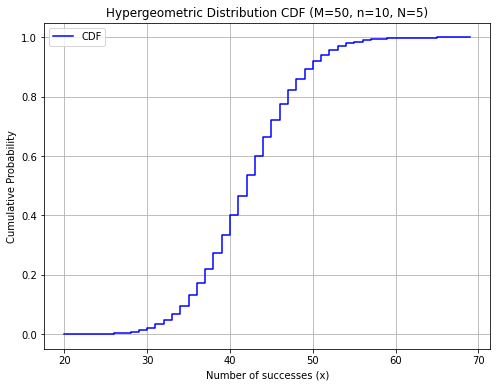

In [44]:
# Create the distribution
cdf = hypergeom.cdf(x, N, K, n)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.step(x, cdf, where='post', label='CDF', color='blue')
plt.title('Hypergeometric Distribution CDF (M=50, n=10, N=5)')
plt.xlabel('Number of successes (x)')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.legend()
plt.show()